# Classification for bank churn

In this notebook we will use BlueCast's recipes for linear models to create a baseline model for the churn dataset. 
The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression
from bluecast.blueprints.preprocessing_recipes import PreprocessingForLinearModels
from bluecast.blueprints.custom_model_recipes import LogisticRegressionModel

from bluecast.preprocessing.feature_types import FeatureTypeDetector

import numpy as np
import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [4]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Define constants

In [5]:
TARGET = "Exited"

# Split off some unseen data for evaluation

In [6]:
eval_size = 35000
train_eval = train.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop(TARGET)

train = train.head(len(train.index) - eval_size)
train = train.reset_index(drop=True)

In [7]:
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,130034,15671973,Chukwuemeka,467,Spain,Male,27.0,2,0.00,2,1.0,1.0,7415.96
1,130035,15807481,Peng,577,Spain,Female,46.0,0,0.00,1,1.0,0.0,158750.53
2,130036,15707473,Toscani,486,France,Male,43.0,2,0.00,1,1.0,1.0,142913.98
3,130037,15603850,Nwagugheuzo,775,France,Female,41.0,2,61681.39,1,1.0,0.0,129937.82
4,130038,15681412,Chibueze,619,Germany,Male,23.0,7,137755.68,2,0.0,0.0,198376.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75
34996,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45
34997,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56
34998,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03


# From eval dataset remove all CustomerIds that were present in train data

This will prevent leakage

In [8]:
train_customers = train["CustomerId"].unique()
train_eval_customers = train_eval["CustomerId"].unique()

train_eval_not_train_customers = [customer for customer in train_eval_customers if customer not in train_customers]

In [9]:
train_eval = train_eval.loc[train_eval["CustomerId"].isin(train_eval_not_train_customers)]
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10,130044,15571465,Kao,682,France,Female,44.0,3,0.00,2,1.0,0.0,158313.96
36,130070,15586521,Hsiung,671,France,Female,39.0,4,116914.37,1,1.0,1.0,184312.66
52,130086,15621490,Chidimma,682,France,Female,31.0,7,0.00,2,0.0,1.0,45424.34
62,130096,15665984,Chiemenam,850,France,Female,59.0,2,0.00,1,1.0,1.0,107558.28
77,130111,15731840,Ojiofor,655,Germany,Female,43.0,6,106441.59,2,1.0,0.0,172792.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34927,164961,15673571,Ejimofor,706,Spain,Male,21.0,9,132678.18,1,1.0,0.0,96858.18
34932,164966,15671312,Chiedozie,749,France,Female,35.0,5,117020.08,2,0.0,1.0,131778.48
34939,164973,15772417,Mazzi,562,France,Male,33.0,5,0.00,2,1.0,0.0,61531.86
34964,164998,15692656,Hsiung,652,France,Male,39.0,2,0.00,2,1.0,0.0,93336.57


In [10]:
target_eval = target_eval.iloc[train_eval.index]

Wow, only 2.3k from 35k customers were not duplicated between train and eval dataset. This would have caused massive leakage.

# Apply learnings from EDA

In [11]:
to_drop = [] # ["id", "CustomerId", "Surname"]

train = train.drop(to_drop, axis=1)
train_eval = train_eval.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# Creating the pipeline

In this section we create the pipeline for our base model.

In [12]:
# Here we automatically detect the numeric columns
feat_type_detector = FeatureTypeDetector()
_ = feat_type_detector.fit_transform_feature_types(train)

INFO:root:Start detecting and casting feature types.
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as constants only: [].
INFO:root:Dropped the following columns as constants only: [].


In [13]:
feat_type_detector.num_columns

['CreditScore',
 'Tenure',
 'NumOfProducts',
 'Exited',
 'Age',
 'Balance',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [14]:
linear_model_preproc = PreprocessingForLinearModels(num_columns=[col for col in feat_type_detector.num_columns if TARGET not in col])
linear_model = LogisticRegressionModel()

In [15]:
automl_baseline = BlueCast(
    class_problem="binary",
    custom_preprocessor=linear_model_preproc, # this takes place right after test_train_split
    ml_model=linear_model,
)

automl_baseline.conf_training.calculate_shap_values = False

2024-08-18 14:49:06,459 - root - INFO - BlueCast blueprint initialized.


2024-08-18 14:49:06,477 - root - INFO - Start detecting and casting feature types.
2024-08-18 14:49:06,491 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-18 14:49:06,492 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-18 14:49:06,514 - root - INFO - Dropped the following columns as constants only: [].
2024-08-18 14:49:06,515 - root - INFO - Dropped the following columns as constants only: [].
2024-08-18 14:49:07,447 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2024-08-18 14

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/thomas/anaconda3/envs/BlueCast/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/thomas/anaconda3/envs/BlueCast/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
2024-08-18 14:51:01,438 - root - WARNING - /home/thomas/anaconda3/envs/BlueCast/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home

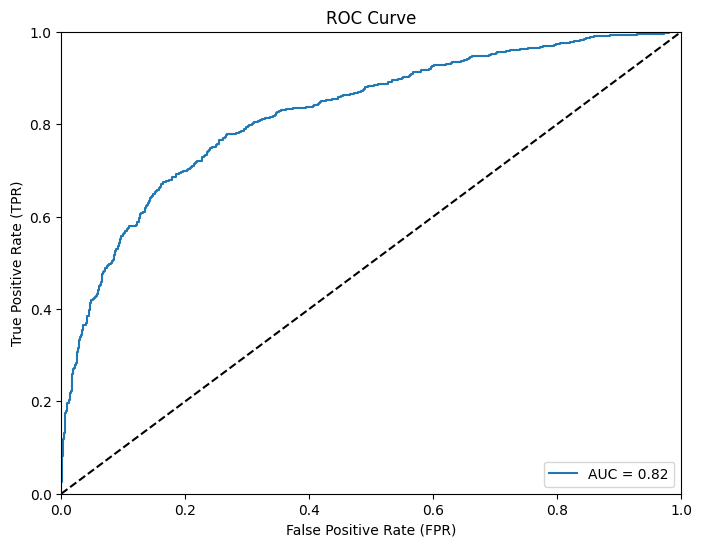

2024-08-18 14:51:02,551 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


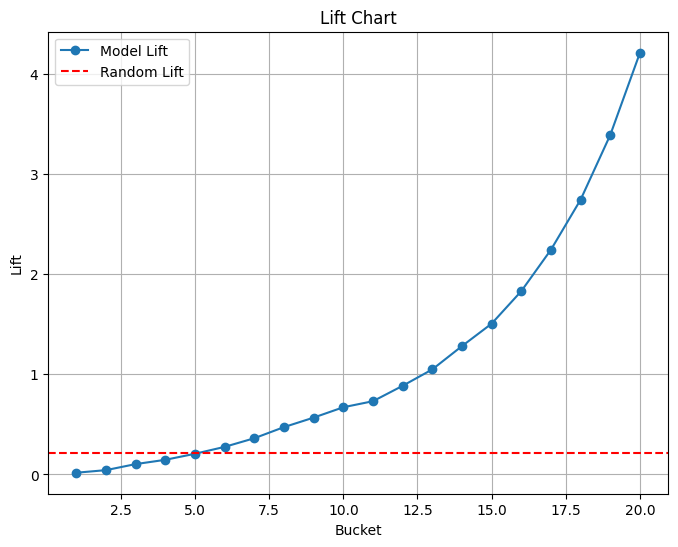

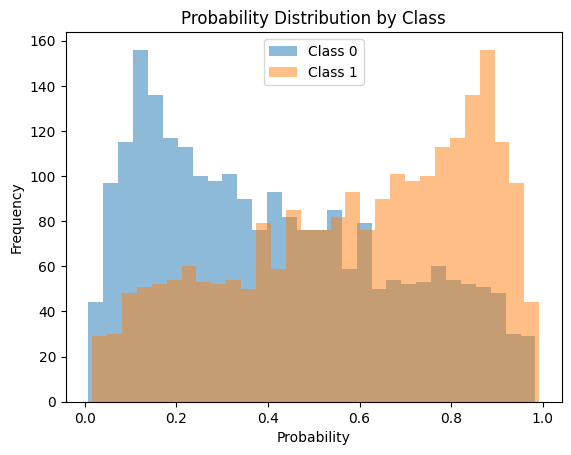

2024-08-18 14:51:02,905 - root - INFO - Start saving out of fold data.


{'matthews': 0.4279723365063041,
 'accuracy': 0.7510748065348237,
 'recall': 0.7510748065348237,
 'f1_score_macro': 0.6930933387722175,
 'f1_score_micro': 0.7510748065348237,
 'f1_score_weighted': 0.7702872612336101,
 'log_loss': 0.5080581560367902,
 'balanced_logloss': 0.5154329752715333,
 'roc_auc': 0.8238550975945934,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.92      0.75      0.83      1836\n           1       0.45      0.75      0.56       490\n\n    accuracy                           0.75      2326\n   macro avg       0.68      0.75      0.69      2326\nweighted avg       0.82      0.75      0.77      2326\n',
 'confusion_matrix': array([[1379,  457],
        [ 122,  368]])}

In [16]:
automl_baseline.fit_eval(
    df=train,
    df_eval=train_eval,
    target_eval=target_eval,
    target_col=TARGET,
)

In [17]:
automl_baseline.ml_model.model.best_estimator_.coef_

array([[-0.06460587, -0.05301572, -0.54275124,  0.88600131, -0.0977888 ,
        -0.09458523, -0.57988337,  0.03906214,  0.74603691, -0.40867406,
        -0.34039474, -0.34225903,  0.33922714]])

In [18]:
automl_baseline.ml_model.model.best_estimator_.feature_names_in_

array(['CreditScore', 'Tenure', 'NumOfProducts', 'Age', 'Balance',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_Germany', 'Geography_France', 'Geography_Spain',
       'Gender_Male', 'Gender_Female'], dtype=object)

In [19]:
y_probs, y_classes = automl_baseline.predict(test)

2024-08-18 14:51:03,026 - root - INFO - Start casting feature types.
2024-08-18 14:51:03,029 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-18 14:51:03,029 - root - INFO - Dropped the following columns as constants only: [].
2024-08-18 14:51:03,093 - root - INFO - Start filling infinite values.
2024-08-18 14:51:03,116 - root - INFO - Start date column conversion.
2024-08-18 14:51:03,117 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-18 14:51:03,122 - root - INFO - Start transforming categories with binary target encoder.
2024-08-18 14:51:03,137 - root - INFO - Start transforming categories with binary target encoder.
2024-08-18 14:51:03,191 - root - INFO - Start transforming categories with binary target encoder.
2024-08-18 14:51:03,192 - root - INFO - Predicting...


In [20]:
submission[TARGET] = y_probs
submission.to_csv("automl_baseline_bluecast_pipeline.csv", index=False)
submission

,id,Exited
0,165034,0.046625
1,165035,0.841220
2,165036,0.359077
3,165037,0.488320
4,165038,0.741944
...,...,...
110018,275052,0.109797
110019,275053,0.348390
110020,275054,0.156195
110021,275055,0.288726


# Summary

Scores without any learnings from EDA:

* 'matthews': 0.0,
* 'accuracy': 0.7893379191745485,
* 'recall': 0.7893379191745485,
* 'log_loss': 0.50773195518088,
* 'balanced_logloss': 0.871187644477746,
* 'roc_auc': 0.577816682228447

Scores with scaled features:

* 'matthews': 0.48399002428568594,
* 'accuracy': 0.8478073946689596,
* 'recall': 0.8478073946689596,
* 'log_loss': 0.37175142944292205,
* 'balanced_logloss': 0.6351457044245439,
* 'roc_auc': 0.8382886487928505

Scores while additionally dropping ["id", "CustomerId", "Surname"]:

* 'matthews': 0.4471658069407588,
* 'accuracy': 0.8383490971625107,
* 'recall': 0.8383490971625107,
* 'log_loss': 0.3861059593822318,
* 'balanced_logloss': 0.659460725609794,
* 'roc_auc': 0.823254857498555

--> Some surnames appear up to 2k times in the training dataset, thus give lots of signal. This is probably an artifact from synthetic data generation. For this dataset we will keep it for better comparison. However never use such data with real data and in real world circumstances!

# What would have been happened afterwards?

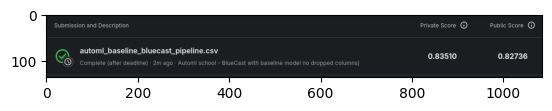

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('automl_baseline_kaggle.png')
imgplot = plt.imshow(img)
plt.show()

The number one score is at 0.90585, so the baseline is quite away here.